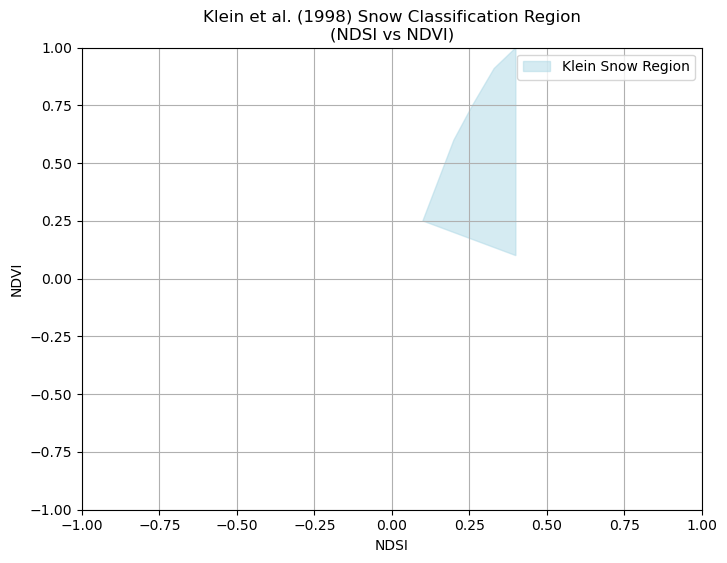

In [1]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import numpy as np

# Define approximate polygon (NDVI, NDSI) → flipped to (NDSI, NDVI)
region_coords = [
    (0.4, 1),
    (0.33, 0.91),
    (0.26, 0.75),
    (0.2, 0.6),
    (0.1, 0.25),  # bottom left
    (0.4, 0.1),  # top right
]

# Extract for plotting
polygon = Polygon(region_coords)
x_poly, y_poly = zip(*polygon.exterior.coords)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))

# Shaded polygon
ax.fill(x_poly, y_poly, color='lightblue', alpha=0.5, label='Klein Snow Region')

# Axes and labels
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_xlabel('NDSI')
ax.set_ylabel('NDVI')
ax.set_title('Klein et al. (1998) Snow Classification Region\n(NDSI vs NDVI)')
ax.grid(True)

ax.legend()
plt.show()


Processing: ../scratch/data/landsat/Landsat7_bartlett80_clouds4_LE07_L1TP_013029_20220323_20220419_02_T1.tif


/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


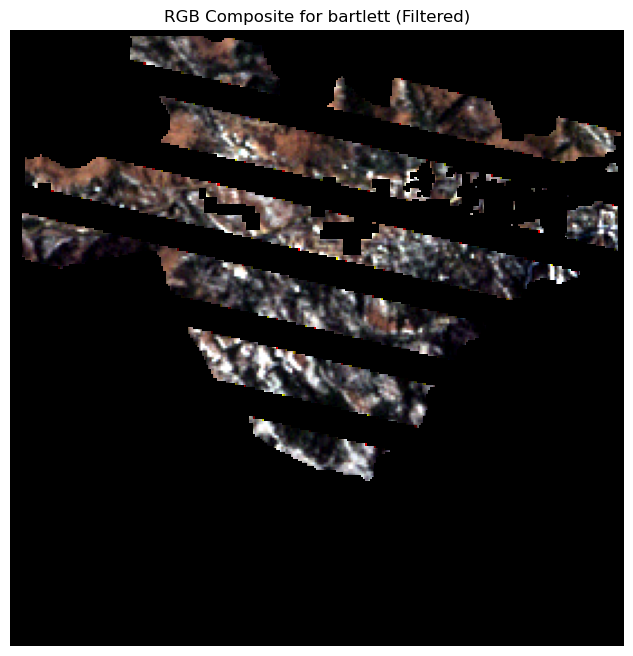

                   mean  filtered_fraction
cell_y cell_x                             
2      4       0.297297           0.730969
3      3       0.243802           0.998270
       4       0.058824           1.000000
       5       0.120083           0.687716
4      2       0.015714           0.874790
       3       0.080933           1.000000
       4       0.046358           1.000000
       5       0.038760           1.000000
       6       0.076923           0.615966
5      0       0.033283           0.972269
       1       0.043165           0.944637
       2       0.047833           0.929931
       3       0.057576           0.909170
       4       0.053719           0.715398
       5       0.136964           0.780277
       6       0.090909           0.518166
       7       0.226782           0.712803
6      2       0.029932           0.986159
       3       0.021948           0.939446
       4       0.023644           0.960208
       5       0.048780           0.911765
       6   

/tmp/ipykernel_2664406/2753870708.py:190: RuntimeWarning: Mean of empty slice
  mean = grouped['data'].agg(lambda v: np.nanmean(v))


In [48]:
from scripts.imports import *
from rasterio.enums import Resampling
from shapely.geometry import Polygon, Point

def find_masks(folder, cam):
    for filename in os.listdir(folder):
        if cam in filename and 'LandCover' in filename:
            corine_filepath = os.path.join(folder, filename)
        elif cam in filename and 'ALOS' in filename:
            elevation_filepath = os.path.join(folder, filename)
    return corine_filepath, elevation_filepath

def load_and_reproject_to_landsat(source_path, match_array, band_name, method=Resampling.nearest):
    src = rioxarray.open_rasterio(source_path, masked=True).squeeze()
    src.name = band_name
    return src.rio.reproject_match(match_array, resampling=method)

def combine_tifs(landsat_filepath, corine_filepath, elevation_filepath):
    landsat = rioxarray.open_rasterio(landsat_filepath, masked=True).squeeze()
    landsat.name = "landsat"
    corine = load_and_reproject_to_landsat(corine_filepath, landsat, "corine_landcover")
    elevation = load_and_reproject_to_landsat(elevation_filepath, landsat, "elevation")
    return xr.merge([landsat, corine, elevation])

def apply_valid_mask(ds):
    elevation = ds['elevation']
    corine = ds['corine_landcover']
    yc, xc = elevation.sizes['y'] // 2, elevation.sizes['x'] // 2
    centre_elev = elevation.isel(y=yc, x=xc).item()
    elev_mask = np.abs(elevation - centre_elev) <= 80
    corine_mask = (corine >= 111) & (corine <= 126)
    valid_mask = elev_mask & corine_mask
    ds['valid_mask'] = valid_mask
    return ds

def compute_ndvi(red, nir):
    return (nir - red) / (nir + red)

def compute_ndsi(green, swir):
    return (green - swir) / (green + swir)

def compute_dozier(ds, ndsi, nir):
    corine = ds['corine_landcover']
    condition1 = (corine >= 111) & (corine <= 126) & (ndsi > 0.1) & (ndsi < 0.4)
    condition2 = ~((corine >= 111) & (corine <= 126)) & (ndsi >= 0.4) & (nir > 0.11)
    dozier = xr.where(condition1 | condition2, 1, 0)
    return dozier.where(~np.isnan(ndsi))

def compute_klein(ndsi, ndvi, green, nir):
    region_coords = [
        (0.4, 1), (0.33, 0.91), (0.26, 0.75),
        (0.2, 0.6), (0.1, 0.25), (0.4, 0.1),
    ]
    polygon = Polygon(region_coords)
    klein = xr.zeros_like(ndsi)
    klein = xr.where(ndsi >= 0.4, 1, klein)
    ndsi_vals, ndvi_vals = ndsi.values, ndvi.values
    mask = np.zeros(ndsi.shape, dtype=bool)
    for i in range(ndsi.shape[0]):
        for j in range(ndsi.shape[1]):
            if not np.isnan(ndsi_vals[i, j]) and not np.isnan(ndvi_vals[i, j]):
                if polygon.contains(Point(ndsi_vals[i, j], ndvi_vals[i, j])):
                    mask[i, j] = True
    klein = xr.where(xr.DataArray(mask, dims=ndsi.dims, coords=ndsi.coords), 1, klein)
    klein = xr.where((green <= 0.1) | (nir <= 0.11), 0, klein)
    return klein.where(~np.isnan(ndsi) & ~np.isnan(ndvi))

def compute_salomonson(ndsi):
    fsc = 0.06 + 1.21 * ndsi
    return fsc.clip(0, 1).where(~np.isnan(ndsi))

def normalize(img):
    img = img.transpose("y", "x", "band")
    p2 = img.quantile(0.02, dim=("x", "y"))
    p98 = img.quantile(0.98, dim=("x", "y"))
    return ((img - p2) / (p98 - p2)).clip(0, 1)

def plot_rgb(ds, landsat, cam, filtered=True):
    rgb_bands = [2, 1, 0] if landsat == 'Landsat7' else [3, 2, 1]
    rgb = ds['landsat'].isel(band=rgb_bands)

    if filtered and 'valid_mask' in ds:
        # Apply valid mask across all bands
        mask = ds['valid_mask']
        rgb = rgb.where(mask)

    rgb = normalize(rgb)

    plt.figure(figsize=(8, 8))
    title = f"RGB Composite for {cam}" + (" (Filtered)" if filtered else " (Raw)")
    plt.imshow(rgb)
    plt.title(title)
    plt.axis("off")
    plt.show()

def process_scene(i, apply_filter=True, plot_rgb_image=True):
    cams = ['bartlett', 'delta_junction', 'glees', 'hyytiala', 'kenttarova', 'lacclair', 'marcell', 'old_jack_pine',
            'oregon', 'queens', 'sodankyla', 'torgnon', 'underc', 'underhill', 'varrio', 'willowcreek', 'wslcreek']

    landsat_folder = '../scratch/data/landsat/'
    landsat_filepaths = sorted([
        os.path.join(landsat_folder, f) for f in os.listdir(landsat_folder)
        if os.path.isfile(os.path.join(landsat_folder, f))
    ])

    cam = [c for c in cams if c in landsat_filepaths[i]][0]
    landsat = [l for l in ['Landsat7', 'Landsat8'] if l in landsat_filepaths[i]][0]
    landsat_masking_folder = '../scratch/data/landsat_masking/'
    corine_fp, elev_fp = find_masks(landsat_masking_folder, cam)
    print(f"Processing: {landsat_filepaths[i]}")
    
    ds = combine_tifs(landsat_filepaths[i], corine_fp, elev_fp)

    ds = apply_valid_mask(ds)

    bgrns = [1, 2, 3, 4, 5] if landsat == 'Landsat7' else [2, 3, 4, 5, 6]
    red, green, blue, nir, swir = [ds['landsat'].isel(band=b - 1) for b in bgrns]

    ndsi = compute_ndsi(green, swir)
    ndvi = compute_ndvi(red, nir)

    dozier = compute_dozier(ds, ndsi, nir)
    klein = compute_klein(ndsi, ndvi, green, nir)
    fsc = compute_salomonson(ndsi)
    if apply_filter:
        dozier = dozier.where(ds['valid_mask'])
        klein = klein.where(ds['valid_mask'])
        fsc = fsc.where(ds['valid_mask'])
    
    ds['Dozier'] = dozier.assign_attrs(name="Dozier")
    ds['Klein'] = klein.assign_attrs(name="Klein")
    ds['Salomonson'] = fsc.assign_attrs(name="Salomonson")

    if plot_rgb_image:
        plot_rgb(ds, landsat, cam, filtered=apply_filter)

    return ds

# Example usage
ds = process_scene(i=0, apply_filter=True, plot_rgb_image=True)

def subcell_stats(ds, var='Salomonson'):
    """
    Compute mean value and valid_mask fraction in fixed 8x8 grid over dataset in meters.

    Args:
        ds (xr.Dataset): Dataset with 2D variable `var` and 'valid_mask'
        var (str): Variable to average (default: 'Salomonson')

    Returns:
        xr.Dataset with dims (cell_y=8, cell_x=8) containing:
            - 'mean': np.nanmean of `var` in each subcell
            - 'filtered_fraction': fraction of valid_mask == True in each subcell
    """
    data = ds[var]
    mask = ds['valid_mask']

    # Get coordinates
    y_vals = data['y'].values
    x_vals = data['x'].values
    yy, xx = np.meshgrid(y_vals, x_vals, indexing="ij")

    flat_y = yy.ravel()
    flat_x = xx.ravel()
    flat_data = data.values.ravel()
    flat_mask = mask.values.ravel()

    # Get bounding box and define 8 even bins in each direction
    y_min, y_max = y_vals.min(), y_vals.max()
    x_min, x_max = x_vals.min(), x_vals.max()

    y_edges = np.linspace(y_min, y_max, 9)  # 8 bins = 9 edges
    x_edges = np.linspace(x_min, x_max, 9)

    # Digitize assigns bin 1–8; subtract 1 → 0–7 for indexing
    cell_y = np.digitize(flat_y, y_edges) - 1
    cell_x = np.digitize(flat_x, x_edges) - 1

    # Keep only points within bin ranges
    valid = (cell_y >= 0) & (cell_y < 8) & (cell_x >= 0) & (cell_x < 8)
    df = pd.DataFrame({
        'cell_y': cell_y[valid],
        'cell_x': cell_x[valid],
        'data': flat_data[valid],
        'mask': flat_mask[valid]
    })

    grouped = df.groupby(['cell_y', 'cell_x'])

    mean = grouped['data'].agg(lambda v: np.nanmean(v))
    filtered_fraction = grouped['mask'].agg(lambda v: np.count_nonzero(v == True) / np.count_nonzero(~np.isnan(v)))

    return xr.Dataset({
        'mean': mean,
        'filtered_fraction': filtered_fraction
    }).unstack()

result = subcell_stats(ds, var='Dozier')

# # Access results
# result['mean']              # np.nanmean of values in each subcell
# result['filtered_fraction'] # % of pixels marked valid in each subcell

print(result.where(result['filtered_fraction'] >= 0.5).to_dataframe().dropna())

# ds

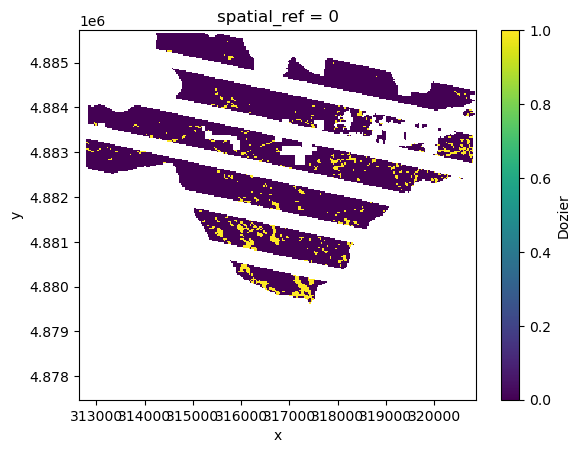

In [47]:
ds['Dozier'].plot()